# LatentSim!

In [1]:
import numpy as np
from latent_sim import LatentSim

In [2]:
ls = LatentSim()

In [3]:
hub = "/Users/afq/Google Drive/networks/training_water_slgc_logp_64/"

In [4]:
ls.load_model(hub+"Classifying_2,6,24,48,sigmoid",
             scale_file="data_files/water_iapw_logp_ranges.csv",logp=True)

INFO:tensorflow:Restoring parameters from /Users/afq/Google Drive/networks/training_water_slgc_logp_64/Classifying_2,6,24,48,sigmoid/final_variables


In [5]:
ls.decode(np.array([[0.0,0.0]]))

array([[3.10543752e+02, 6.25445078e+03, 3.04714587e+02, 1.80102337e+06]])

# Finding initial conditions

We know we only need 2 variables to specify a point on the surface. Most of the time we just want to provide a p and a T. 
However, the econder assumes that the input is on the manifold. 
The user could go through the effort of looking up rho and h, but that's a pain!
We want to let the user specify only 2 numbers and find the intersection on the manifold.

If we just try to plug in the result with "reasonable" fillers for the two unknowns we notice that we encoded onto the wrong point on the manifold:

In [45]:
ls.o_s

<tf.Tensor 'concat_10:0' shape=(?, 4) dtype=float64>

In [6]:
q = ls.encode(np.array([[250.0, 1.0e3, ls.scale[0,2],ls.scale[0,3]]]))
print q
print ls.decode(q)

[[ 0.1714474  -0.10976305]]
[[2.88290312e+02 1.73476431e+03 5.22802547e+02 1.16577663e+06]]


This means:
\begin{equation}
T,p \neq D_{Tp}(E(T,p,?,?))
\end{equation}
Unfortunately this means we have to start solving the equations.
\begin{equation}
R(q) = D_{Tp}(q) - \{T^*,p^*\}
\end{equation}
with a good initial guess of
\begin{equation}
q^0 = E(T^*,p^*,?,?)
\end{equation}

In [7]:
ls.encode(
    np.array([[2.50000000e+02, 1.00000000e+03, 5.41351758e+02 ,1.35349597e+06]]) )

array([[ 0.17651276, -0.11644305]])

We can wrap this process up in a nice interface,

In [20]:
q0 = ls.find_point(T=650,p=5.0e4)

25.154806178775107 [[0.18792801 0.08456129]]
7.132070394317886 [[ 0.67664905 -0.02104055]]
17.237547960980493 [[ 0.61343397 -0.51702831]]
0.653195540413448 [[ 0.93304275 -0.13251534]]
0.32457085737709745 [[0.75008818 0.33280995]]
13.994587063552757 [[0.51990963 0.10397798]]
1493.832870932847 [[ 0.06736855 -0.10864039]]
40.116212471174336 [[-0.39609186  0.07898812]]
367.0830987390669 [[ 0.09107992 -0.0335448 ]]
7.884844365106723 [[-0.38570617  0.11703746]]
9.934535584695627 [[0.11056142 0.17801678]]
0.3687039854132859 [[-0.35842426  0.35137316]]
0.09759861475962266 [[-0.03150571  0.5218633 ]]
0.0482566012087557 [[-0.12571267  0.49635767]]
0.038608572707627256 [[-0.17372338  0.49149229]]
0.03285288958472671 [[-0.21223002  0.48868874]]
0.025650520431228545 [[-0.24494278  0.48565757]]
0.014766095786342972 [[-0.27044401  0.48289416]]
0.004095321192526582 [[-0.2851059   0.48114304]]
0.00025911302923292933 [[-0.28916879  0.48062862]]
9.656967438677506e-07 [[-0.28942573  0.48059516]]
1.3347322

Note that we're working in 32-bit precision, so that's as close as we're going to get!

# Building the equations

The user shouldn't need to run this themselves.

In [9]:
ls.build_dae()

# Running a simulation

We can set a schedule for properties. In this scheme, we're imposing a path on the phase diagram that will start it in Ice, sublimate it to high-temperature gas, move it around the critical point through the supercritical regime to liquid, and then evaporate it to gas.

In [51]:
q0 = ls.find_point(T=350,p=5.0e6)
ls.set_params(k_p=1.0e-6,k_T=10000.0)
def schedule(sim,t):
    if t<1000.0:
        sim.set_params(T_inf=350,p_inf=5.0e7)    

59.996386034572936 [[0.18792801 0.08456129]]
23.122691198053634 [[-0.29952509  0.19586929]]
4.124521861618768 [[0.19957654 0.22582864]]
7.358304701897256 [[-0.29342681  0.30918148]]
10.762264559091603 [[0.20171928 0.37868218]]
0.04250095947072678 [[0.6710769  0.20633536]]
0.014552547215460022 [[0.68200903 0.16526444]]
0.0035855103159656 [[0.67112339 0.15560632]]
0.0001803140670724896 [[0.66830497 0.15338993]]
4.315942322781519e-07 [[0.6681629  0.15327889]]
Found point at  [[3.50000000e+02 5.00000000e+06 9.75839199e+02 3.28079231e+05]]  after  9  iterations.


In [34]:
q0 = ls.find_point(T=650,p=5.0e4)
def schedule(sim,t):
    if t<1000.0:
        sim.set_params(T_inf=800,p_inf=5.0e4)
    elif t<2000.0:
        sim.set_params(T_inf=800,p_inf=3.0e7)
    elif t<3000.0:
        sim.set_params(T_inf=400,p_inf=3.0e7)
    elif t<4000.0:
        sim.set_params(T_inf=400,p_inf=5.0e3)

25.154806178775107 [[0.18792801 0.08456129]]
7.132070394317886 [[ 0.67664905 -0.02104055]]
17.237547960980493 [[ 0.61343397 -0.51702831]]
0.653195540413448 [[ 0.93304275 -0.13251534]]
0.32457085737709745 [[0.75008818 0.33280995]]
13.994587063552757 [[0.51990963 0.10397798]]
1493.832870932847 [[ 0.06736855 -0.10864039]]
40.116212471174336 [[-0.39609186  0.07898812]]
367.0830987390669 [[ 0.09107992 -0.0335448 ]]
7.884844365106723 [[-0.38570617  0.11703746]]
9.934535584695627 [[0.11056142 0.17801678]]
0.3687039854132859 [[-0.35842426  0.35137316]]
0.09759861475962266 [[-0.03150571  0.5218633 ]]
0.0482566012087557 [[-0.12571267  0.49635767]]
0.038608572707627256 [[-0.17372338  0.49149229]]
0.03285288958472671 [[-0.21223002  0.48868874]]
0.025650520431228545 [[-0.24494278  0.48565757]]
0.014766095786342972 [[-0.27044401  0.48289416]]
0.004095321192526582 [[-0.2851059   0.48114304]]
0.00025911302923292933 [[-0.28916879  0.48062862]]
9.656967438677506e-07 [[-0.28942573  0.48059516]]
1.3347322

In [52]:
Dt = 0.05
ls.set_params(Dt=Dt)
t = 0
t_max = 20.0
q = q0.copy()
qs,ss,ts = [],[],[]
while t<t_max:
    t+=Dt
    schedule(ls,t)
    q = ls.solve_a_time_step(q)
    if np.isnan(q).any() or np.isinf(q).any():
        print "NaN encountered at t=",t
        break
    qs.append(q.copy())
    ss.append(ls.decode(q).copy())
    ts.append(t)

21 3.905128591228877e-12
15 3.237658602077557e-10
12 3.3613346430969494e-11
9 1.8856036825546633e-07
8 1.3690656440528822e-11
6 1.4982837516060557e-07
6 3.007394647920174e-13
5 1.2943055574824704e-11
4 2.1583321172668168e-10
4 6.638499250588349e-12
3 4.3458723698261444e-10
3 9.176726646279337e-11
3 1.2533916150681286e-11
3 5.831519067890842e-13
2 3.654226982390547e-10
2 2.9291007836135595e-10
2 1.5766730955102089e-10
2 8.551670513667226e-11
2 4.669031641266753e-11
2 2.5636526064620376e-11
2 1.4146407978757367e-11
2 7.838909824765745e-12
2 4.359712059955762e-12
2 2.4321266074247515e-12
2 1.3608724546791703e-12
2 7.63404546515019e-13
2 4.289148656884993e-13
1 1.7607559171369262e-07
1 1.321640713021427e-07
1 9.927147317530523e-08
1 7.460845094669437e-08
1 5.610027246824774e-08
1 4.22007847566194e-08
1 3.175583866376073e-08
1 2.3902646229250402e-08
1 1.7995418826056568e-08
1 1.3550259350488935e-08
1 1.020423212404261e-08
1 7.684903319857651e-09
1 5.787626924012065e-09
1 4.358583929454738e-

In [53]:
ts = np.array(ts)
ss = np.array(ss)
qs = np.array(qs)

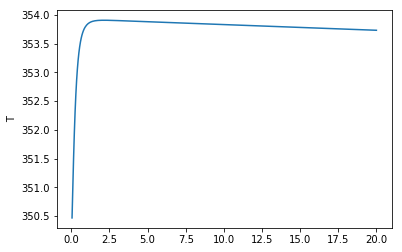

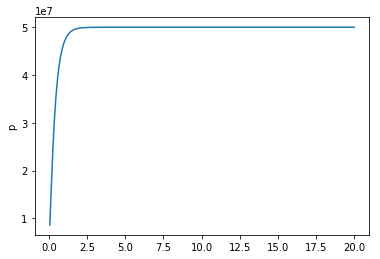

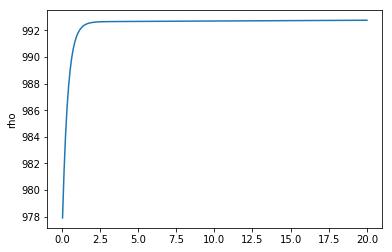

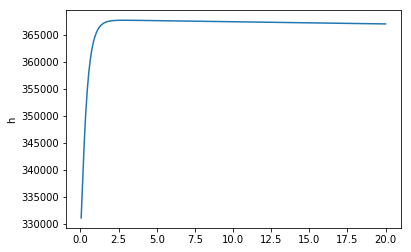

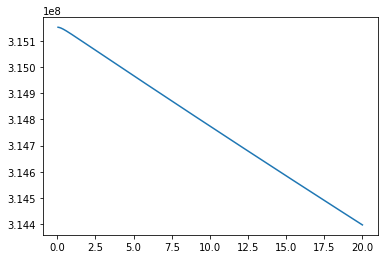

In [54]:
from matplotlib import pylab as plt
%matplotlib inline
legends=['T','p','rho','h']
for i,name in enumerate(legends):
    plt.figure()
    plt.plot(ts,ss[:,0,i])
    plt.ylabel(name)
plt.figure()
plt.plot(ts,ss[:,0,2]*ss[:,0,3]-ss[:,0,1])

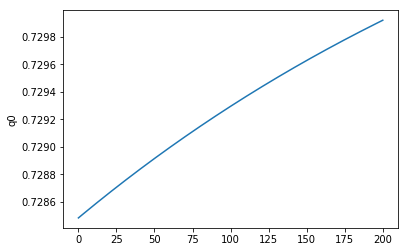

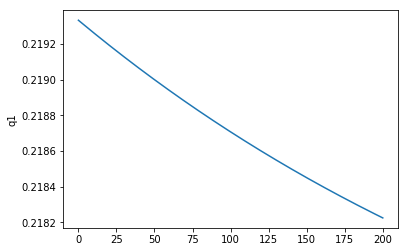

In [50]:
legends=['q0','q1']
for i,name in enumerate(legends):
    plt.figure()
    plt.plot(ts,qs[:,0,i])
    plt.ylabel(name)